In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
review_df = pd.concat(
    map(pd.read_csv, ['amazonreviews.csv', 'amazonreviews2.csv','amazonreviews3.csv']), ignore_index=True)
review_df

,title,rating,review
0,great for a gift,4.0,"more like a cookie, so not good to dip in coffee"
1,yum,4.0,expensive but good
2,Not bad but.....,4.0,A nice box for presentation. The flavors were ...
3,Perfect gift!,5.0,This gift was perfect for my sister (who lives...
4,Even though it wasn’t that great - the seller ...,4.0,It’s very taste dependent.
...,...,...,...
3418,Fresh,5.0,Recipient was thrilled with packaging and fres...
3419,Great gift item,5.0,Wonderful chocolates.
3420,Can’t go wrong!,5.0,"These are always a winner, the price point is ..."
3421,For GODIVA these taste bland,5.0,I liked how my family ate it in one sitting. I...


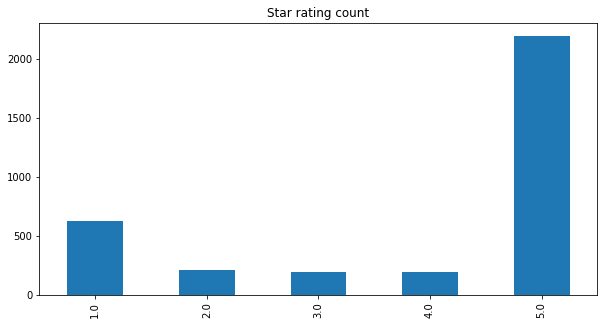

In [7]:
# EDA
plot = review_df['rating'].value_counts().sort_index() \
       .plot(kind='bar', title='Star rating count', figsize=(10,5))
plt.show()

      rating                                             review
0          1   more like a cookie, so not good to dip in coffee
1          1                                 expensive but good
2          1  A nice box for presentation. The flavors were ...
3          1  This gift was perfect for my sister (who lives...
4          1                         It’s very taste dependent.
...      ...                                                ...
3418       1  Recipient was thrilled with packaging and fres...
3419       1                              Wonderful chocolates.
3420       1  These are always a winner, the price point is ...
3421       1  I liked how my family ate it in one sitting. I...
3422       1                                       Perfect gift

[3411 rows x 2 columns]


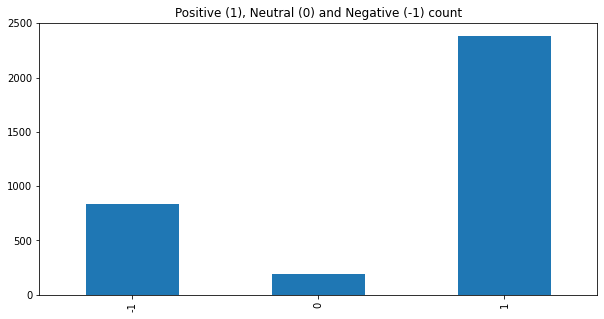

In [8]:
# Preprocessing

# Drop useless columns
review_df = review_df.drop(columns=['title'],axis=1)

# Drop missing values
review_df = review_df.dropna(subset=['review','rating'])

# Convert to string
def convert2str(review_df):
    return str(review_df['review'])

review_df['review'] = review_df.apply(convert2str,axis=1)

# Convert rating into class labels - positive, negative and neutral
def assign_label(review_df):
    rating = str(review_df['rating'])
    if rating == '5.0' or rating == '4.0':
        return 1
    elif rating == '2.0' or rating == '1.0' or rating == '0':
        return -1
    elif rating == '3.0':
        return 0

review_df['rating'] = review_df.apply(assign_label,axis=1)

print(review_df)
plot = review_df['rating'].value_counts().sort_index() \
       .plot(kind='bar', title='Positive (1), Neutral (0) and Negative (-1) count', figsize=(10,5))
plt.show()

<class 'str'>


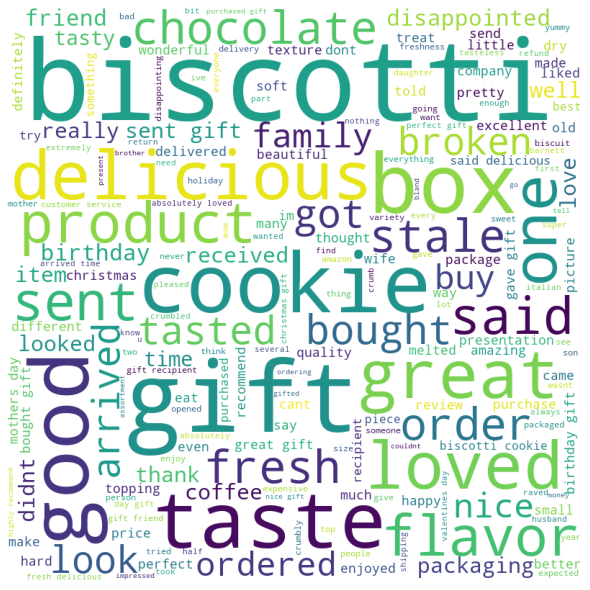

In [9]:
import nltk, re, string
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

total_doc = ''

lemmatizer = WordNetLemmatizer()

# Tokenize and Lemmatize
def tokenize(review_df):
    doc = review_df['review']
    cleandoc = re.sub('[^A-Za-z0-9 ]+', '', doc).lower()
    nltk_stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.tokenize.word_tokenize(cleandoc)
    for i,val in enumerate(tokens):
        tokens[i] = lemmatizer.lemmatize(val)
    tokens=[token.strip() \
                for token in nltk.word_tokenize(cleandoc.lower()) \
                if token.strip() not in nltk_stopwords and    
                token.strip() not in string.punctuation]
    
    return ' '.join([i for i in tokens if not i.isdigit()])

review_df['review'] = review_df.apply(tokenize,axis=1)
total_doc = ' '.join(review_df['review'])
print(type(total_doc))
#print(review_df)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(str(total_doc))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

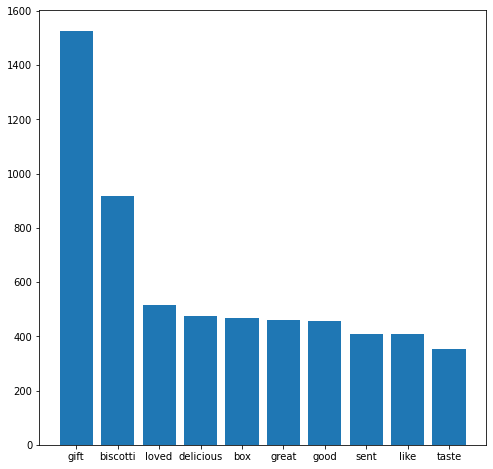

In [10]:
import collections
wordcount = collections.defaultdict(int)

for word in total_doc.split():
    wordcount[word] += 1

mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:10]
mc = dict(mc)
names = list(mc.keys())
values = list(mc.values())
plt.figure(figsize = (8, 8))
plt.bar(range(len(mc)),values,tick_label=names)
#plt.savefig('bar.png')
plt.show()

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
from sklearn import metrics

# Evaluation

def evaluation(model_type, y_true, y_pred):
    print('\n Model: ', str.upper(model_type))
    print('Accuracy score: ',accuracy_score(y_true,y_pred))
    labels = ['Class -1','Class 0','Class 1']
    print(classification_report(y_true, y_pred, target_names=labels))
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [-1,0,1])
    cm_display.plot()
    plt.show()
    

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

# Finding best paramters
def search_para(docs, y, model_type):

    if model_type == 'svm':
        text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', svm.LinearSVC())
                    ])
    elif model_type == 'nb':
        text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())
                    ])
    elif model_type == 'lr':
         text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression())
                    ])
    
    if model_type == 'nb':
        parameters = {'tfidf__min_df':[1,3,2,4,5],
                'tfidf__stop_words':[None,"english"],
                'clf__alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                }
    elif model_type == 'lr':
        parameters = {'tfidf__min_df':[1,3,2,4,5],
                'tfidf__stop_words':[None,"english"],
                'clf__penalty': ['l2','l1','elasticnet'],
                'clf__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                'clf__solver':['lbfgs','sag','saga','newton-cg']
                }
    else:
        parameters = {'tfidf__min_df':[1,3,2,4,5],
                'tfidf__stop_words':[None,"english"],
                'clf__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                }
    
    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)
    gs_clf = gs_clf.fit(docs, y)

    print('\nModel: ',str.upper(model_type))
    for param_name in gs_clf.best_params_:
        print("{0}:\t{1}".format(param_name, gs_clf.best_params_[param_name]))

    print("best f1 score: {:.3f}".format(gs_clf.best_score_))

In [13]:
from sklearn.model_selection import train_test_split

X = review_df['review'].values
y = review_df['rating'].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Get Best Parameters
search_para(X_train,y_train,'svm')
search_para(X_train,y_train,'nb')
search_para(X_train,y_train,'lr')


Model:  SVM
clf__C:	0.9
tfidf__min_df:	1
tfidf__stop_words:	None
best f1 score: 0.618

Model:  NB
clf__alpha:	0.1
tfidf__min_df:	4
tfidf__stop_words:	english
best f1 score: 0.596

Model:  LR
clf__C:	0.9
clf__penalty:	l1
clf__solver:	saga
tfidf__min_df:	4
tfidf__stop_words:	english
best f1 score: 0.569



 Model:  NB
Accuracy score:  0.861328125
              precision    recall  f1-score   support

    Class -1       0.80      0.78      0.79       267
     Class 0       0.25      0.02      0.03        63
     Class 1       0.89      0.97      0.93       694

    accuracy                           0.86      1024
   macro avg       0.64      0.59      0.58      1024
weighted avg       0.82      0.86      0.84      1024



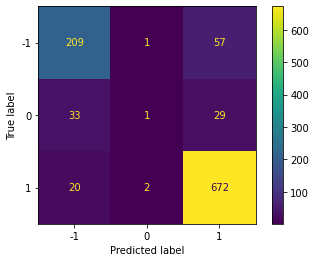


 Model:  SVM
Accuracy score:  0.8564453125
              precision    recall  f1-score   support

    Class -1       0.80      0.77      0.78       267
     Class 0       0.09      0.02      0.03        63
     Class 1       0.89      0.97      0.93       694

    accuracy                           0.86      1024
   macro avg       0.59      0.58      0.58      1024
weighted avg       0.82      0.86      0.83      1024



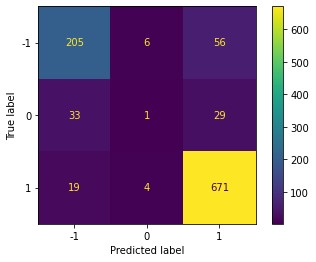


 Model:  LR
Accuracy score:  0.845703125
              precision    recall  f1-score   support

    Class -1       0.80      0.72      0.75       267
     Class 0       0.00      0.00      0.00        63
     Class 1       0.86      0.97      0.91       694

    accuracy                           0.85      1024
   macro avg       0.55      0.56      0.56      1024
weighted avg       0.79      0.85      0.82      1024



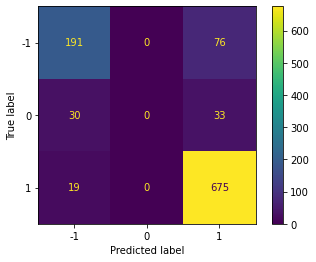

In [15]:
# Feature Extraction
X = review_df['review'].values
y = review_df['rating'].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Feature Extraction
tfidf_vect = TfidfVectorizer(min_df=4,stop_words='english')
X_train = tfidf_vect.fit_transform(X_train)
X_test = tfidf_vect.transform(X_test)


# Modeling

# Naive Bayes
clf_nb = MultinomialNB(alpha=0.1)
clf_nb.fit(X_train,y_train)
pred_nb = clf_nb.predict(X_test)
evaluation('nb',y_test,pred_nb)

# SVM
clf_svm = svm.LinearSVC(C=0.9)
clf_svm.fit(X_train,y_train)
pred_svm = clf_svm.predict(X_test)
evaluation('svm',y_test,pred_svm)



# LR
clf_lr = LogisticRegression(C=0.9,solver='saga',penalty='l1')
clf_lr.fit(X_train,y_train)
pred_lr = clf_lr.predict(X_test)
evaluation('LR',y_test,pred_lr)
